In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # put -1 to not use any

In [4]:
import math
import pandas as pd

import matplotlib.pyplot as plt
import SimpleITK as sitk

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage


In [ ]:
def separate_bottom_top_curve(cnt):
  ## need to visualize curves to understand why this split
  cnt_length = cnt.shape[0]

  start_pt = int(cnt_length/4)-1
  middle_length = int(cnt_length/2)-1
  top_cnt1= cnt[:start_pt][::-1]
  top_cnt2= cnt[-start_pt:][::-1]

  bottom_cnt = cnt[start_pt:start_pt+middle_length]
  top_cnt = np.concatenate([top_cnt1, top_cnt2])

  return bottom_cnt, top_cnt

def adjust_array(bottom, top):
  ## to adjust the edges that are not perfect -> still not perfect :(
  max_x_position = np.argmax(bottom[:,0])
  min_x_position = np.argmin(bottom[:,0])

  keep_bottom = bottom[min_x_position:max_x_position]
  add_top_r = bottom[max_x_position:][::-1]
  add_top_l = bottom[:min_x_position][::-1]

  new_top = np.concatenate([add_top_l, top, add_top_r])
  return keep_bottom, new_top


def compute_distances_and_matches(contour_1, contour_2, smooth_factor=14):

    distances=[]
    matches = []
    for i in range(len(contour_1)):
        point_contour_1 = contour_1[i]
        if i > 0 and i < len(contour_1) - 1:
            tangent = contour_1[i+1] - contour_1[i-1]
        elif i == 0:
            tangent = contour_1[i+1] - contour_1[i]
        else:
            tangent = contour_1[i] - contour_1[i-1]
        
        # Calculate normal (perpendicular to tangent) --> Rotate tangent by 90 degrees: (x,y) -> (-y,x)
        normal = np.array([-tangent[1], tangent[0]])
        normal = normal / np.linalg.norm(normal)

        # Find the closest point on top curve
        # this is not perfect when you display the matches/segments, don't know why/how fix it
        distances_to_all = cdist([point_contour_1], contour_2)[0]
        closest_idx = np.argmin(distances_to_all)
        closest_point = contour_2[closest_idx]
        
        matches.append((point_contour_1, closest_point))
        connection_vector = closest_point - point_contour_1
        distance_along_normal = np.dot(connection_vector, normal)
        
        distances.append(abs(distance_along_normal))
        
    distances= np.array(distances)

    smooth_distances = ndimage.gaussian_filter1d(distances, sigma=smooth_factor)

    return smooth_distances, contour_1[:,0], matches

def resample_top_curve(points, target_len):
    
    diffs = np.diff(points, axis=0)
    seg_lengths = np.hypot(diffs[:,0], diffs[:,1])
    dist = np.concatenate([[0], np.cumsum(seg_lengths)])
    new_dist = np.linspace(0, dist[-1], target_len)
    
    x_new = np.interp(new_dist, dist, points[:,0])
    y_new = np.interp(new_dist, dist, points[:,1])
    
    return np.column_stack((x_new, y_new))


In [3]:
df = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg.csv')

seg_column='seg'
class_column='class'
mount_point='/CMF/data/lumargot/trachoma/PoPP_Data/mtss'

In [ ]:
# all_heights, all_x, all_classes,files = read_data(df, mount_point)

In [210]:
import torch
import cv2
from scipy.spatial.distance import cdist


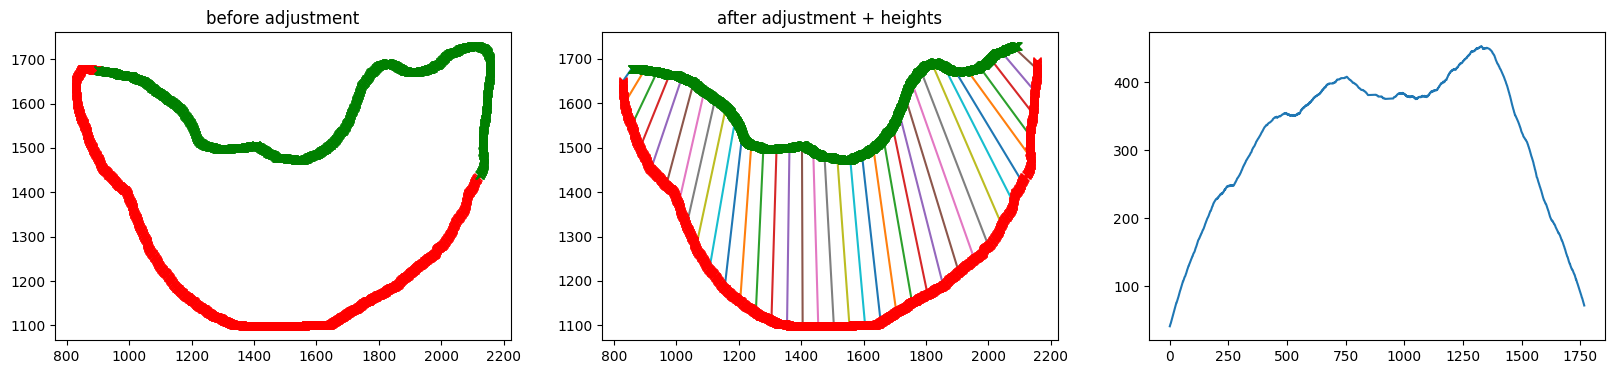

In [259]:
row = df.iloc[6]
  
seg_path = os.path.join(mount_point, row['seg'])
seg = torch.tensor(sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).copy())
if len(np.unique(seg))==1 or  len(np.unique(seg)) == 3 :
  print(seg_path)

elif len(np.unique(seg))>1:
  if len(np.unique(seg)) == 2: ## contain only eyelid 
    eyelid_seg = seg.float()
      
  else:# if contain entire eye segmented
    eyelid_seg = (seg == 3).float()

  mask255 = (eyelid_seg.numpy() * 255).astype(np.uint8)
  contours, _ = cv2.findContours(mask255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cnt = max(contours, key=cv2.contourArea).squeeze()

  cnt_top, cnt_bottom = separate_bottom_top_curve(cnt)
  plt.figure(figsize=(20,4))
  plt.subplot(131)
  plt.plot(cnt_bottom[:,0], cnt_bottom[:,1], 'xr')
  plt.plot(cnt_top[:,0], cnt_top[:,1], 'xg')
  plt.title('before adjustment')

  cnt_bottom, cnt_top = adjust_array(cnt_bottom, cnt_top)
  cnt_top, cnt_bottom = adjust_array(cnt_top, cnt_bottom)

  ## adjust borders -
  max_left_y = np.argmax(cnt_top[:300,1])
  max_right_y = np.argmax(cnt_top[-300:,1])
  pos_left = cnt_top.shape[0] - 300

  cnt_top = cnt_top[max_left_y:pos_left+max_right_y]

  ## downsample bottom
  # cnt_bottom_down = cnt_bottom[np.linspace(0, len(cnt_bottom)-1, cnt_top.shape[0], dtype=int)]

  ## upsample top
  cnt_top_resampled = resample_top_curve(cnt_top, target_len=cnt_bottom.shape[0])

  diff = cnt_top_resampled - cnt_bottom
  squared_diff = np.square(diff)
  sum_squared_diff = np.sum(squared_diff,axis=1)
  distance = np.sqrt(sum_squared_diff)

  plt.subplot(132)

  for idx in range(0,cnt_top_resampled.shape[0], 50):
    dx = [cnt_bottom[idx,0], cnt_top_resampled[idx,0]]
    dy = [cnt_bottom[idx,1], cnt_top_resampled[idx,1]]
    plt.plot(dx, dy)

  plt.plot(cnt_top_resampled[:,0], cnt_top_resampled[:,1], 'xg')
  plt.plot(cnt_bottom[:,0], cnt_bottom[:,1], 'xr')
  plt.title('after adjustment + heights')

  plt.subplot(133)
  plt.plot(np.arange(distance.shape[0]),distance)

